In [1]:
!pip install -U bitsandbytes accelerate datasets trl


In [2]:
# TOKEN


TOKEN=""


In [3]:
from huggingface_hub import login

login(token=TOKEN)

/home/andrew/miniconda3/envs/llm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:

import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, BitsAndBytesConfig, AutoConfig, Seq2SeqTrainingArguments, Seq2SeqTrainer


base_model = "google-t5/t5-large"
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


torch_dtype = torch.bfloat16

# Configuartion of model quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch_dtype,
    bnb_4bit_use_double_quant=True,
)

tokenizer = AutoTokenizer.from_pretrained(base_model)

model = AutoModelForSeq2SeqLM.from_pretrained(
    base_model,
    device_map = "cuda:0",
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16,
)

In [6]:
model

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear4bit(in_features=1024, out_features=1024, bias=False)
              (k): Linear4bit(in_features=1024, out_features=1024, bias=False)
              (v): Linear4bit(in_features=1024, out_features=1024, bias=False)
              (o): Linear4bit(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear4bit(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=Fal

In [7]:
tokenizer

T5TokenizerFast(name_or_path='google-t5/t5-large', vocab_size=32100, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<ext

In [10]:
input_text = "Exterior like fish "
input_ids = tokenizer(input_text, return_tensors="pt").to("cuda")

outputs = model.generate(**input_ids, max_new_tokens=100, temperature=0.7, do_sample=True)
print(tokenizer.decode(outputs[0]))

<pad><extra_id_0> fish.</s>


In [11]:
input_text = "Mediterranean Roasted Chicken\n\nIngredients:\n"
input_ids = tokenizer(input_text, return_tensors="pt").to("cuda")

outputs = model.generate(**input_ids, max_new_tokens=200, temperature=0.7, do_sample=True)
print(tokenizer.decode(outputs[0]))

<pad><extra_id_0> &<extra_id_1>: Lemon, Olive Oil, & Ginger; Roasted chicken, Mediterranean<extra_id_2>ed Chicken<extra_id_3>: Organic, Mediterranean, Mediterranean Chicken Proteins: Italian, & Olive Oil; Mediterranean<extra_id_4> Mediterranean Roasted Chicken. Served with Lemon and olive oil.<extra_id_5> Chicken Mediterranean<extra_id_6> Chicken Mediterranean Roasted Chicken Ingredients:<extra_id_7>ing<extra_id_8> Mediterranean Roasted Chicken<extra_id_9> chicken<extra_id_10> chicken<extra_id_11> Mediterranean<extra_id_12> chicken<extra_id_13> chicken<extra_id_14> chicken<extra_id_15> chicken<extra_id_16> chicken<extra_id_17> Mediterranean<extra_id_18> Mediterranean<extra_id_19>in<extra_id_20> Ingredients<extra_id_21> Chicken<extra_id_22></s>


In [12]:
import pandas as pd
import numpy as np
import torch
import transformers
import datasets
from datasets import Dataset
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import peft
from trl import SFTConfig, SFTTrainer
import json


# Datset Grabbing

In [13]:
dataset = datasets.load_dataset("json", data_files={"train": "masked_man_pages.json"}, split="train")
df = pd.DataFrame(dataset)
df = df.drop_duplicates()


Generating train split: 20419 examples [00:01, 10350.64 examples/s]


In [14]:
df.describe()

,input,output
count,20419,20419
unique,17633,19219
top,<SECTION>REPORTING BUGS</SECTION>\nGNU coreuti...,<SECTION>SYNOPSIS</SECTION>\nopenssl cmd -help...
freq,102,51


In [16]:
df = pd.DataFrame(dataset)
df = df.drop_duplicates(subset=["input"])
df = df.drop_duplicates(subset=["output"])

df.describe()
seed = 42  # Set your desired seed
# df = df.sample(n=2000, random_state=seed)
df = df.reset_index(drop=True)

dataset = Dataset.from_pandas(df)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17628 entries, 0 to 17627
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   17628 non-null  object
 1   output  17628 non-null  object
dtypes: object(2)
memory usage: 275.6+ KB


Median: 1.0
Mean: 1
STD: 0.0


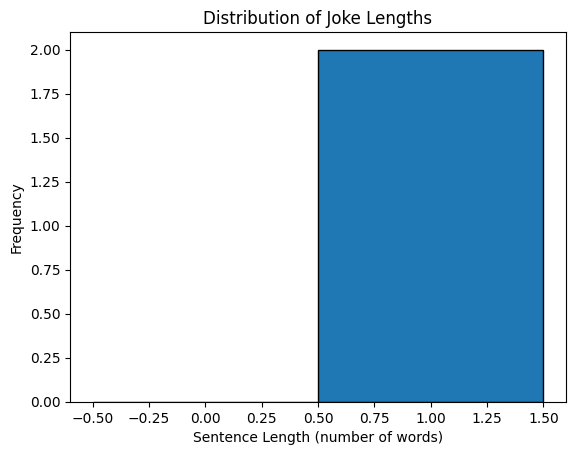

In [18]:
import statistics as stats

lengths = [len(str(item).split()) for item in df]
lengths.sort(reverse=True)

print(f"Median: {stats.median(lengths)}")
print(f"Mean: {stats.mean(lengths)}")
print(f"STD: {stats.stdev(lengths)}")

plt.hist(lengths, bins=range(max(lengths) + 2), align='left', edgecolor='black')
plt.xlabel('Sentence Length (number of words)')
plt.ylabel('Frequency')
plt.title('Distribution of Joke Lengths')
plt.show()

In [19]:
final_ds = dataset.train_test_split(0.2)

In [20]:
print(final_ds)

DatasetDict({
    train: Dataset({
        features: ['input', 'output'],
        num_rows: 14102
    })
    test: Dataset({
        features: ['input', 'output'],
        num_rows: 3526
    })
})


In [21]:
print(final_ds["train"].column_names)

['input', 'output']


In [23]:
def formatting_func(example):
    # Minimal formatting, directly using input and output fields
    return [f"{example['input']}\n{example['output']}"]
    
def format_and_tokenize_batch(examples):
    input_texts = [f"manpage: {inp}" for inp in examples["input"]]
    target_texts = examples["output"]

    input_encodings = tokenizer(
        input_texts,
        max_length=1024,
        padding="max_length",
        truncation=True,
    )
    target_encodings = tokenizer(
        target_texts,
        max_length=512,
        padding="max_length",
        truncation=True,
    )

    # Apply label masking
    labels = [
        [(label if label != tokenizer.pad_token_id else -100) for label in target]
        for target in target_encodings["input_ids"]
    ]

    return {
        "input_ids": input_encodings["input_ids"],
        "attention_mask": input_encodings["attention_mask"],
        "labels": labels,
    }

# Apply the batch-friendly function
tokenized_ds = final_ds.map(
    format_and_tokenize_batch,
    batched=True,  # Process examples in batches
    remove_columns=["input", "output"],  # Remove original columns
)

Map: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3526/3526 [00:18<00:00, 194.05 examples/s]


In [24]:
final_ds["train"][2]
# tokenized_ds["train"][0]

{'input': '<SECTION>FILES</SECTION>\n/usr/share/tabset\n              tab stop initialization database',
 'output': "<SECTION>NAME</SECTION>\ntabs - set terminal tab stops\n<SECTION>SYNOPSIS</SECTION>\ntabs [options] [tabstop-list]\n<SECTION>DESCRIPTION</SECTION>\nThe  tabs program clears and sets tab-stops on the terminal.  This uses\n       the terminfo clear_all_tabs and set_tab capabilities.  If either is ab‐\n       sent, tabs is unable to clear/set tab-stops.  The  terminal  should  be\n       configured to use hard tabs, e.g.,\n\n           stty tab0\n\n       Like  clear(1),  tabs  writes to the standard output.  You can redirect\n       the standard output to a file (which prevents tabs from actually chang‐\n       ing the tabstops), and later cat the file to the screen,  setting  tab‐\n       stops at that point.\n\n       These  are  hardware  tabs, which cannot be queried rapidly by applica‐\n       tions running in the terminal, if at all.  Curses and other full-screen\n  

# Setting up the model+training parameters
Here we are going to setup our LoRA config. LoRA, or LOw-Rank Adaptation, uses advanced linear algebra to reduce the number of parameters we need to change.

In [25]:
import bitsandbytes as bnb

def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:  # needed for 16 bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

modules = find_all_linear_names(model)

In [26]:
modules

['v', 'q', 'o', 'k', 'wi']

In [27]:
print(final_ds["train"].column_names)

['input', 'output']


In [28]:
# from numba import cuda
# from datasets import load_metric
#
# label_pad_token_id = -100
#
# # Load the ROUGE metric
# metric = load_metric("rouge")
#
# # Data collator
# data_collator = transformers.DataCollatorForSeq2Seq(
#     tokenizer,
#     model=model,
#     label_pad_token_id=label_pad_token_id,
#     pad_to_multiple_of=8,
# )
#
# new_model = "t5-3b-man-pages"
# # Setting Hyperparamter
# training_arguments = transformers.TrainingArguments(
#     output_dir=new_model,
#     per_device_train_batch_size=1,
#     per_device_eval_batch_size=1,
#     gradient_accumulation_steps=1,
#     optim="paged_adamw_32bit",
#     num_train_epochs=1,
#     eval_strategy="steps",
#     eval_steps = 0.25,
#     logging_steps=1,
#     warmup_steps=10,
#     logging_strategy="steps",
#     learning_rate=2e-4,
#     fp16=True,
#     bf16=False,
#     group_by_length=True,
#     report_to = "none",
# )
# trainer = SFTTrainer(
#     model=model,
#     train_dataset=tokenized_ds["train"],
#     eval_dataset=tokenized_ds["test"],
#     peft_config=peft_config,
#     data_collator=data_collator,
#     tokenizer=tokenizer,
#     max_seq_length=512,
#     args=training_arguments,
#     packing=False,
#
# )

In [35]:
base_model = "google-t5/t5-large"
new_model = "t5-large-man-pages"
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


torch_dtype = torch.bfloat16

# Configuartion of model quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch_dtype,
    bnb_4bit_use_double_quant=True,
)

peft_config = peft.LoraConfig(
    task_type=peft.TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    r=4,
    lora_alpha=32,
    lora_dropout=0.01,
    target_modules=modules
)

tokenizer = AutoTokenizer.from_pretrained(base_model)
model = AutoModelForSeq2SeqLM.from_pretrained(
    base_model,
    device_map = "cuda:0",
    quantization_config=bnb_config,
    torch_dtype=torch_dtype,
)

batch_size = 1
model_name = "t5-large"

model = peft.get_peft_model(model, peft_config)

training_args = Seq2SeqTrainingArguments(
    output_dir=new_model,
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy="steps",
    eval_steps = 0.125,
    save_total_limit=3,
    num_train_epochs=2,
    predict_with_generate=True,
    fp16=False,
    bf16=True,
    push_to_hub=True,
    report_to="none",
)

label_pad_token_id=-100

data_collator = transformers.DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)

trainer = Seq2SeqTrainer(
    model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    # compute_metrics=compute_metrics
)

/tmp/ipykernel_3179/1374162215.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [36]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss
3526,2.957900,2.718952
7052,2.746200,2.541682
10578,2.677100,2.439495
14104,2.623300,2.382997
17630,2.571400,2.335387
21156,2.503100,2.309675
24682,2.456800,2.290718


TrainOutput(global_step=28204, training_loss=2.712096088102668, metrics={'train_runtime': 10378.3436, 'train_samples_per_second': 2.718, 'train_steps_per_second': 2.718, 'total_flos': 1.2270516582324634e+17, 'train_loss': 2.712096088102668, 'epoch': 2.0})

In [31]:
# trainer.model.save_pretrained(f"{model_name}-finetuned-xsum")
trainer.model.save_pretrained(new_model)
trainer.model.push_to_hub(new_model, use_temp_dir=False)



adapter_model.safetensors: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.48M/9.48M [00:03<00:00, 2.43MB/s]


CommitInfo(commit_url='https://huggingface.co/asdfasda112312/t5-large-man-pages/commit/711442f5cfd9f4a8b3c6f49648d6c903b726d4cf', commit_message='Upload model', commit_description='', oid='711442f5cfd9f4a8b3c6f49648d6c903b726d4cf', pr_url=None, repo_url=RepoUrl('https://huggingface.co/asdfasda112312/t5-large-man-pages', endpoint='https://huggingface.co', repo_type='model', repo_id='asdfasda112312/t5-large-man-pages'), pr_revision=None, pr_num=None)

In [ ]:
# # prompt: zip t5-large-man-pages and then download
# 
# !zip -r t5-large-man-pages.zip t5-large-man-pages
# !ls
# from google.colab import files
# files.download('t5-large-man-pages.zip')

In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

shared.weight: requires_grad=False
encoder.block.0.layer.0.SelfAttention.q.base_layer.weight: requires_grad=False
encoder.block.0.layer.0.SelfAttention.q.lora_A.default.weight: requires_grad=True
encoder.block.0.layer.0.SelfAttention.q.lora_B.default.weight: requires_grad=True
encoder.block.0.layer.0.SelfAttention.k.base_layer.weight: requires_grad=False
encoder.block.0.layer.0.SelfAttention.k.lora_A.default.weight: requires_grad=True
encoder.block.0.layer.0.SelfAttention.k.lora_B.default.weight: requires_grad=True
encoder.block.0.layer.0.SelfAttention.v.base_layer.weight: requires_grad=False
encoder.block.0.layer.0.SelfAttention.v.lora_A.default.weight: requires_grad=True
encoder.block.0.layer.0.SelfAttention.v.lora_B.default.weight: requires_grad=True
encoder.block.0.layer.0.SelfAttention.o.base_layer.weight: requires_grad=False
encoder.block.0.layer.0.SelfAttention.o.lora_A.default.weight: requires_grad=True
encoder.block.0.layer.0.SelfAttention.o.lora_B.default.weight: requires_gra

In [ ]:
from huggingface_hub import login

login(token=TOKEN)

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline
from peft import PeftModel
import torch

base_model_url = "google-t5/t5-large"
new_model = "asdfasda112312/t5-large-man-pages"

# Reload tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(base_model_url)

base_model_reload = AutoModelForSeq2SeqLM.from_pretrained(
    base_model_url,
    torch_dtype=torch.bfloat16,
)

In [ ]:
model = PeftModel.from_pretrained(base_model_reload, new_model)

model = model.merge_and_unload()

ValueError: Target modules {'base_layer'} not found in the base model. Please check the target modules and try again.

In [ ]:
# model.save_pretrained("t5-3b-man-pages-merged")
# model.push_to_hub("t5-3b-man-pages-merged", use_temp_dir=False)


model.safetensors: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.88G/1.88G [11:31<00:00, 2.72MB/s]


CommitInfo(commit_url='https://huggingface.co/asdfasda112312/t5-3b-man-pages-merged/commit/0a09219b386fac2ad7bcaca839d395383ec6be77', commit_message='Upload T5ForConditionalGeneration', commit_description='', oid='0a09219b386fac2ad7bcaca839d395383ec6be77', pr_url=None, repo_url=RepoUrl('https://huggingface.co/asdfasda112312/t5-3b-man-pages-merged', endpoint='https://huggingface.co', repo_type='model', repo_id='asdfasda112312/t5-3b-man-pages-merged'), pr_revision=None, pr_num=None)

In [36]:
input_text = "<SECTION>NAME</SECTION>codeshit - write shit code"
input_ids = tokenizer(input_text, return_tensors="pt").to("cuda:0")

outputs = model.generate(**input_ids, max_new_tokens=1024, temperature=0.8, do_sample=True)
print(tokenizer.decode(outputs[0]))

<pad> <unk>SECTION>NAME<unk>/SECTION> codeshit - write a shit code <unk>SECTION>SYNOPSIS<unk>/SECTION> shit [-H] <unk>SECTION>DESCRIPTION<unk>/SECTION> shit writes code shit. On command line, shit reports the error code and gives the user instructions to write the code. Use shit to write the code. <unk>SECTION>SEE CUT STAT(1)</s>
